In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from Bio.Data import CodonTable
from matplotlib import pyplot as plt
from scipy.stats import linregress, gmean
from skbio.sequence.distance import hamming
from skbio.sequence import Sequence

# Analysis of Z_C conservation in the genetic code.

1. Hydrophobicity and Z_C correlate. Code is conservative for hydrophobicity, e.g. Haig & Hurst 1991. 

* This data is in the aa_nosc.csv file now. Just plotting correlations.

2. Calculate Z_C consequences of transitions in the standard code. Need multiple subs to change Z_C. 

* We tabulate all the transitions and their Z_C consequences below. 

3. Use an empirical contingency table to estimate real-ish rates. 

* Above analysis ignores relative rates of transitions. 

In [2]:
# Amino acid properties
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv')

In [3]:
# Grab the standard codon table
cdn_table = CodonTable.unambiguous_dna_by_name["Standard"]

# DataFrame mapping codons => amino acids, Z_C
fwd_dict = cdn_table.forward_table
codons = sorted(fwd_dict.keys())
aas = [fwd_dict[k] for k in codons]

cdn_df = pd.DataFrame(dict(aa=aas, codon=codons))
cdn_df['NOSC'] = aa_nosc_df.set_index('letter_code').loc[cdn_df.aa.values].NOSC.values

# Consider all possible codon transitions.
subs_dict = dict(from_codon=[], to_codon=[], from_NOSC=[], to_NOSC=[], from_aa=[], to_aa=[], hamming_dist=[])
for idx, row1 in cdn_df.iterrows():
    for jdx, row2 in cdn_df.iterrows():
        if idx >= jdx:
            # Only consider half the symmetric matrix
            continue 
        
        subs_dict['from_codon'].append(row1.codon)
        subs_dict['to_codon'].append(row2.codon)
        subs_dict['from_aa'].append(row1.aa)
        subs_dict['to_aa'].append(row2.aa)
        subs_dict['from_NOSC'].append(row1.NOSC)
        subs_dict['to_NOSC'].append(row2.NOSC)
        
        # skbio hamming is fractional change.
        # hence hamming*length = number of mutations between seqs
        hd = hamming(Sequence(row1.codon), Sequence(row2.codon))*3
        subs_dict['hamming_dist'].append(hd)
        
# Convert to DF
subs_df = pd.DataFrame(subs_dict)
# positive dNOSC = more reduced sub
subs_df['dNOSC'] = subs_df.to_NOSC - subs_df.from_NOSC
# Since codon subs can go in either direction, abs dNOSC is the value of interest
subs_df['abs_dNOSC'] = subs_df.dNOSC.abs()

subs_df.to_csv('../data/genetic_code/all_codon_substitutions.csv', index=False)

In [4]:
# Bin them by absolute delta NOSC and take the mean.
bins = pd.cut(subs_df.abs_dNOSC, 10)
bins.name = 'abs_dNOSC_bin'
codon_subs_mean_df = subs_df.groupby(bins).mean()
codon_subs_std_df = subs_df.groupby(bins).std()

# Calculate the bin midpoint for plotting below
codon_subs_mean_df['midpoint_abs_dNOSC'] = [np.mean([a.left, a.right]) for a in codon_subs_mean_df.index]
codon_subs_mean_df['abs_dNOSC_std'] = codon_subs_std_df['abs_dNOSC']
codon_subs_mean_df['hamming_dist_std'] = codon_subs_std_df['hamming_dist']

codon_subs_mean_df.to_csv('../data/genetic_code/binned_codon_substitutions.csv')

In [5]:
codon_subs_mean_df

,from_NOSC,to_NOSC,hamming_dist,dNOSC,abs_dNOSC,midpoint_abs_dNOSC,abs_dNOSC_std,hamming_dist_std
abs_dNOSC_bin,,,,,,,,
"(-0.002, 0.2]",-0.074000,-0.061055,1.872727,0.012945,0.049600,0.099,0.076860,0.746147
"(0.2, 0.4]",0.218114,0.194341,2.356589,-0.023773,0.332558,0.300,0.050740,0.676762
"(0.4, 0.6]",-0.194014,-0.224218,2.183673,-0.030204,0.562721,0.500,0.054378,0.702446
"(0.6, 0.8]",0.024851,0.173881,2.279851,0.149030,0.711567,0.700,0.057785,0.647702
"(0.8, 1.0]",-0.039128,-0.007641,2.358974,0.031487,0.966154,0.900,0.061762,0.684406
"(1.0, 1.2]",0.235079,-0.196825,2.269841,-0.431905,1.111270,1.100,0.046562,0.686005
"(1.2, 1.4]",-0.067108,-0.061205,2.463855,0.005904,1.352651,1.300,0.054095,0.619301
"(1.4, 1.6]",0.134286,-0.067143,2.714286,-0.201429,1.461429,1.500,0.013675,0.455842
"(1.6, 1.8]",0.022391,-0.152971,2.326087,-0.175362,1.700145,1.700,0.055064,0.674489


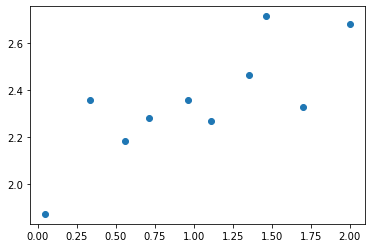

In [6]:
plt.scatter(codon_subs_mean_df.abs_dNOSC, codon_subs_mean_df.hamming_dist)

In [7]:
subs_df.groupby(bins).count()

,from_codon,to_codon,from_NOSC,to_NOSC,from_aa,to_aa,hamming_dist,dNOSC,abs_dNOSC
abs_dNOSC_bin,,,,,,,,,
"(-0.002, 0.2]",275,275,275,275,275,275,275,275,275
"(0.2, 0.4]",387,387,387,387,387,387,387,387,387
"(0.4, 0.6]",147,147,147,147,147,147,147,147,147
"(0.6, 0.8]",268,268,268,268,268,268,268,268,268
"(0.8, 1.0]",195,195,195,195,195,195,195,195,195
"(1.0, 1.2]",126,126,126,126,126,126,126,126,126
"(1.2, 1.4]",166,166,166,166,166,166,166,166,166
"(1.4, 1.6]",56,56,56,56,56,56,56,56,56
"(1.6, 1.8]",138,138,138,138,138,138,138,138,138
